In [66]:
# Author: C. Hull (github: chat.hull)

# This is a project analyzing historical data of the air quality in Santiago, Chile

# The data for a representative weather station in central Santiago can be found here:
# https://sinca.mma.gob.cl/index.php/estacion/index/key/D14

# Shout-outs to the many posts/github pages that helped me out!
# Julia Kho: web scraping, https://towardsdatascience.com/how-to-web-scrape-with-python-in-4-minutes-bc49186a8460
# Aditya Sharma: time-series moving averages, https://www.datacamp.com/community/tutorials/moving-averages-in-pandas
# Manish Pathak: concatenating/merging in pandas, https://www.datacamp.com/community/tutorials/joining-dataframes-pandas
# Laura Fedoruk: time-series manipulation in pandas, https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea

In [67]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import requests
from bs4 import BeautifulSoup
import time
from datetime import date
from matplotlib import pyplot as plt

In [68]:
def isfloat(x) :
    try:
        float(x)
        return True
    except:
        return False

In [69]:
# Scrape SINCA website

# Many pollutants, but different stations don't have continuous time coverage of all of them
# SO2, NO, NO2, CO, O3, NOX, non-methanic hydrocarbons, PM10, PM2.5

# For now, focus on PM10, PM2.5, and weather data at the Parque O'Higgins station in central Santiago
station = 'D14'
# Earliest common date is 031215 (constrained by weather data)
date_from = '031215'
# Current date
date_to = date.today().strftime("%y%m%d")

#PM2.5
pm25 = {
    'name' : 'pm2.5',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Cal/PM25//PM25.horario.horario.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

#PM10
pm10 = {
    'name' : 'pm10',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Cal/PM10//PM10.horario.horario.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Relative humidity
rhum = {
    'name' : 'rhum',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/RHUM//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Temperature
temp = {
    'name' : 'temp',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/TEMP//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Wind speed
wspd = {
    'name' : 'wspd',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/WSPD//horario_000.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

# Wind direction
wdir = {
    'name' : 'wdir',
    'url' : 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/'+station+'/Met/WDIR//horario_000_spec.ic&from='+date_from+'&to='+date_to+'&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
}

In [70]:
def scrapeData(series_url) :
    time.sleep(1)
    response = requests.get(series_url)
    print(response)
    return response

def formatData(html_response) :
    data = html_response.text.split('\n')
    # Clear header and footer text
    data = [ line for line in data if len(line) and isfloat(line[0]) ]
    # Keep lines with date, time, and validated or preliminary data
    data = [ line.split(',')[0:4] for line in data if \
            isfloat(line.split(',')[2]) or isfloat(line.split(',')[3]) ]
    return data

In [71]:
# Empty dataframe; will merge other columns into it one by one
df_tot = pd.DataFrame(columns=['datetime'])

for series in [pm25, pm10, rhum, temp, wspd, wdir] :
    response = scrapeData(series['url'])
    data = formatData(response)
    
    # Format dates
    df = pd.DataFrame.from_records(data, columns=['date', 'time', 'validated', 'preliminary'])
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%y%m%d %H%M')
    df = df.drop(columns=['date', 'time'])
    
    # Combine validated and preliminary-data columns (after replacing white space with NaNs)
    df = df.replace(r'^\s+$', np.nan, regex=True)
    df[series['name']] = df['validated'].combine_first(df['preliminary'])
    df = df.drop(columns=['validated','preliminary'])
    
    # Convert unicode to floats
    df[series['name']] = pd.to_numeric(df[series['name']])
    
    # Merge latest time-series into full DataFrame, resort index
    df_tot = pd.merge(df_tot, df, on='datetime', how='outer')
    df_tot = df_tot.sort_values('datetime')
    df_tot = df_tot.reset_index(drop=True)

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [73]:
print(df_tot.tail(n=15))

                  datetime  pm2.5  pm10     rhum     temp      wspd     wdir
157921 2022-01-13 23:00:00    NaN   NaN  62.0000  18.5917  0.328336  141.284
157922 2022-01-14 00:00:00    NaN   NaN  64.9167  17.7833  0.863634  134.738
157923 2022-01-14 01:00:00    NaN   NaN  65.4167  17.1250  0.889378  129.646
157924 2022-01-14 02:00:00    NaN   NaN  67.9167  16.4583  1.001350  142.277
157925 2022-01-14 03:00:00    NaN   NaN  69.2500  15.9500  0.771066  153.969
157926 2022-01-14 04:00:00    NaN   NaN  71.0833  15.3917  0.083285  195.032
157927 2022-01-14 05:00:00    NaN   NaN  74.5833  14.9417  0.008333  117.000
157928 2022-01-14 06:00:00    NaN   NaN  72.5000  15.7667  0.654604  139.377
157929 2022-01-14 07:00:00    NaN   NaN  64.9167  17.9167  0.834655  139.614
157930 2022-01-14 08:00:00    NaN   NaN  59.2500  19.7583  0.682256  138.182
157931 2022-01-14 09:00:00    NaN   NaN  51.7500  22.4583  0.621297  130.188
157932 2022-01-14 10:00:00    NaN   NaN  46.5000  24.9000  0.088501  145.584

In [74]:
# Set datetime column as the index of the dataframe
df_tot = df_tot.set_index('datetime')

In [75]:
## This may not be necessary given the resample feature
# df_tot['pm2.5run'] = df_tot['pm2.5'].rolling(window=4).mean()
# df_tot['pm10run']  = df_tot['pm10'].rolling(window=4).mean()
# df_tot['rhumrun']  = df_tot['rhum'].rolling(window=4).mean()
# df_tot['temprun']  = df_tot['temp'].rolling(window=4).mean()
# df_tot['wspdrun']  = df_tot['wspd'].rolling(window=4).mean()
# df_tot['wdirrun']  = df_tot['wdir'].rolling(window=4).mean()

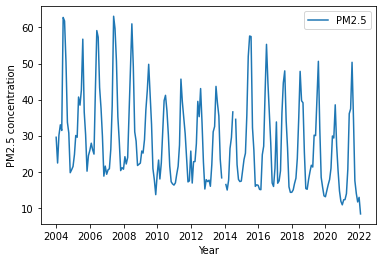

In [76]:
# Sample plot: resampled (monthly) PM2.5 concentration vs. year
##### WE CAN SEE A CLEAR DECREASE AS A FUNCTION OF TIME, 
#####   WITH THE WINTER PEAKS AND SUMMER TROUGHS REGISTERING LOWER VALUES ON AVERAGE.
#####   STRANGELY, THIS IS SOMETHING I HAVE NEVER HEARD ON THE NEWS.  I ASSUME IT'S BECAUSE
#####   EMISSION FROM CARS IS PROGRESSIVELY DECREASING AS OLDER CARS ARE TAKEN OFF THE ROAD.
t_min='2000-01-01'
t_max='2030-01-01'
plt.plot(df_tot['pm2.5'][t_min:t_max].resample('M').mean(),'-', label='PM2.5')
#plt.plot(df_tot['pm10'][t_min:t_max].resample('M').mean(),'-', label='PM10')
#plt.plot(df_tot['temp'][t_min:t_max].resample('M').mean(),'-', label='humidity')
plt.xlabel('Year')
plt.ylabel('PM2.5 concentration')
plt.legend()

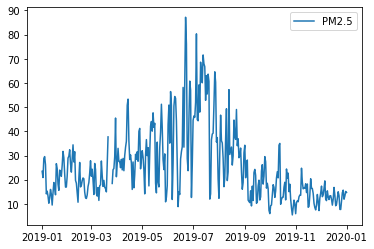

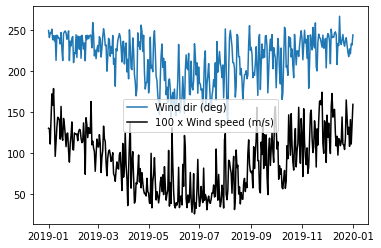

In [81]:
# Sample plots
# Top: resampled (daily) PM2.5 concentration as a function of time in 2019 (pre-pandemic year)
# Bottom: resampled (daily) wind direction (deg) and wind speed (m/s, rescaled by 100x) with the same time range
##### THERE ARE CLEAR CORRELATIONS BETWEEN PM2.5 CONCENTRATION AND BOTH WIND DIRECTION AND WIND SPEED.  
##### IN THE WINTER THE WIND DIES DOWN, AND THUS THE POLLUTION IS NOT BLOWN AWAY.
##### THE CHANGE IN WIND DIRECTION FROM THE WEST=270 DEG IN THE SUMMER VS. THE SOUTH=180 DEG IN THE WINTER
#####    DESERVES FURTHER EXPLORATION.

t_min='2019-01-01'
t_max='2020-01-01'
plt.figure()
plt.plot(df_tot['pm2.5'][t_min:t_max].resample('D').mean(),'-', label='PM2.5')
plt.legend()
plt.figure()
plt.plot(df_tot['wdir'][t_min:t_max].resample('D').mean(),'-', label='Wind dir (deg)')
plt.plot(100*df_tot['wspd'][t_min:t_max].resample('D').mean(),'k-', label='100 x Wind speed (m/s)')
plt.legend()

In [78]:
# TO DO: 
# Do PCA on the time series and remove the annual and diurnal signals
# Test correlations: positive (PM2.5 and PM10), and negative (temp and rhum)

In [79]:
# Print out URLs and enter in your browser to download test files
pm25['url']
#wspd['url']
#pm10['url']
#rhum['url']

'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/D14/Cal/PM25//PM25.horario.horario.ic&from=031215&to=220114&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='